# Point Source Aperture Photometry

**Use case:** Photometry, cross-match catalogs, derive and apply photometric zeropoint.<br>
**Data:**  NIRCam simulated images obtained using [MIRAGE](https://jwst-docs.stsci.edu/jwst-other-tools/mirage-data-simulator) and run through the [JWST pipeline](https://jwst-pipeline.readthedocs.io/en/latest/) of the Large Magellanic Cloud (LMC) Astrometric Calibration Field. Simulations is obtained using a 4-pt subpixel dither for three couples of wide filters: F070W, F115W, and F200W for the SW channel, and F277W, F356W, and F444W for the LW channel. We simulated only 1 NIRCam SW detector (i.e., "NRCB1"). For this example, we use Level-3 images (calibrated and rectified) for two SW filters (i.e., F115W and F200W) and derive the aperture photometry in each one of them. The images for the other filters are also available and can be used to test the notebook and/or different filters combination.<br>
**Tools:** astropy, photutils.<br>
**Cross-intrument:** NIRSpec, NIRISS, MIRI.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

Final plots show:

* Instrumental Color-Magnitude Diagrams and errors
* Magnitudes Zeropoints 
* Calibrated Color-Magnitude Diagram (compared with Input Color-Magnitude Diagram)
* Comparison between input and output photometry

## Import Functions

In [1]:
import os
import sys
import time

import numpy as np

import pandas as pd

import glob as glob

import tarfile

import urllib.request

import jwst
from jwst.datamodels import ImageModel

from astropy.io import fits
from astropy.table import Table
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.visualization import simple_norm
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u

from photutils.detection import DAOStarFinder
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

## Import Plotting Functions

In [2]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 30
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 30

font1 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '12'}
font2 = {'family': 'helvetica', 'color': 'black', 'weight': 'normal', 'size': '20'}

## Load Images and create some useful dictionaries

We load all the images and we create a dictionary that contains all of them, divided by detectors and filters. This is useful to check which detectors and filters are available and to decide if we want to perform the photometry on all of them or only on a subset (for example, only on the SW filters). 

We also create a dictionary with some useful parameters for the analysis. The dictionary contains the photometric zeropoints (from [MIRAGE](https://jwst-docs.stsci.edu/jwst-other-tools/mirage-data-simulator) configuration files) and the NIRCam point spread function (PSF) FWHM, from the [NIRCam Point Spread Function](https://jwst-docs.stsci.edu/near-infrared-camera/nircam-predicted-performance/nircam-point-spread-functions) JDox page. The FWHM are calculated from the analysis of the expected NIRCam PSFs simulated with [WebbPSF](https://www.stsci.edu/jwst/science-planning/proposal-planning-toolbox/psf-simulation-tool). 

**Note**: this dictionary will be updated once the values for zeropoints and FWHM will be available for each detectors/filters after commissioning.

Hence, we have two dictionaries:

* dictionary for the Level-3 images
* dictionary with some other useful parameters

In [3]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_filter_short = {}
dict_filter_long = {}

ff_short = []
det_short = []
det_long = []
ff_long = []
detlist_short = []
detlist_long = []
filtlist_short = []
filtlist_long = []

if not glob.glob('./*combined*fits'):

    print("Downloading images")

    boxlink_images_lev3 = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/images_level3.tar.gz'
    boxfile_images_lev3 = './images_level3.tar.gz'
    urllib.request.urlretrieve(boxlink_images_lev3, boxfile_images_lev3)

    tar = tarfile.open(boxfile_images_lev3, 'r')
    tar.extractall()

    images_dir = './'
    images = sorted(glob.glob(os.path.join(images_dir, "*combined*fits")))

else:

    images_dir = './'
    images = sorted(glob.glob(os.path.join(images_dir, "*combined*fits")))

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'NRCBLONG':
        d = 'NRCB5'
    elif d == 'NRCALONG':
        d = 'NRCA5'
    else:
        d = d

    wv = float(f[1:3])

    if wv > 24:
        ff_long.append(f)
        det_long.append(d)

    else:
        ff_short.append(f)
        det_short.append(d)

    detlist_short = sorted(list(dict.fromkeys(det_short)))
    detlist_long = sorted(list(dict.fromkeys(det_long)))

    unique_list_filters_short = []
    unique_list_filters_long = []

    for x in ff_short:

        if x not in unique_list_filters_short:

            dict_filter_short.setdefault(x, {})

    for x in ff_long:
        if x not in unique_list_filters_long:
            dict_filter_long.setdefault(x, {})

    for d_s in detlist_short:
        dict_images[d_s] = dict_filter_short

    for d_l in detlist_long:
        dict_images[d_l] = dict_filter_long

    filtlist_short = sorted(list(dict.fromkeys(dict_filter_short)))
    filtlist_long = sorted(list(dict.fromkeys(dict_filter_long)))

    if len(dict_images[d][f]) == 0:
        dict_images[d][f] = {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)

print("Available Detectors for SW channel:", detlist_short)
print("Available Detectors for LW channel:", detlist_long)
print("Available SW Filters:", filtlist_short)
print("Available LW Filters:", filtlist_long)

Available Detectors for SW channel: ['NRCB1']
Available Detectors for LW channel: ['NRCB5']
Available SW Filters: ['F070W', 'F115W', 'F200W']
Available LW Filters: ['F277W', 'F356W', 'F444W']


In [4]:
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2', 'F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987, 1.103, 1.298, 1.553, 1.628, 1.770, 1.801, 1.494, 1.990, 2.060, 2.141, 2.304, 2.341, 1.340,
            1.444, 1.585, 1.547, 1.711, 1.760, 1.830, 1.901, 2.165, 2.179, 2.300, 2.302, 2.459, 2.507, 2.535, 2.574]

zp_modA = [25.7977, 25.9686, 25.8419, 24.8878, 27.0048, 25.6536, 24.6957, 22.3073, 24.8258, 22.1775, 25.3677, 24.3296,
           22.1036, 22.7850, 23.5964, 24.8239, 23.6452, 25.3648, 20.8604, 23.5873, 24.3778, 23.4778, 20.5588,
           23.2749, 22.3584, 23.9731, 21.9502, 20.0428, 19.8869, 21.9002]

zp_modB = [25.7568, 25.9771, 25.8041, 24.8738, 26.9821, 25.6279, 24.6767, 22.2903, 24.8042, 22.1499, 25.3391, 24.2909,
           22.0574, 22.7596, 23.5011, 24.6792, 23.5769, 25.3455, 20.8631, 23.4885, 24.3883, 23.4555, 20.7007,
           23.2763, 22.4677, 24.1562, 22.0422, 20.1430, 20.0173, 22.4086]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i], 'VegaMAG zp modA': zp_modA[i],
                           'VegaMAG zp modB': zp_modB[i]} for i in range(len(filters))}

## Select the detectors and/or filters for the analysis

If we are interested only in some filters (and/or some detectors) in the analysis, as in this example, we can select the images from the dictionary for those filters (detectors) and analyze only those images.

In this particular example, we analyze images for filters **F115W** and **F200W** for the detector **NRCB1**.

In [5]:
dets_short = ['NRCB1']  # detector of interest in this example
filts_short = ['F115W', 'F200W']  # filters of interest in this example

## Display the images

To check that our images do not present artifacts and can be used in the analysis, we display them. 

findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.
findfont: Font family 'helvetica' not found.


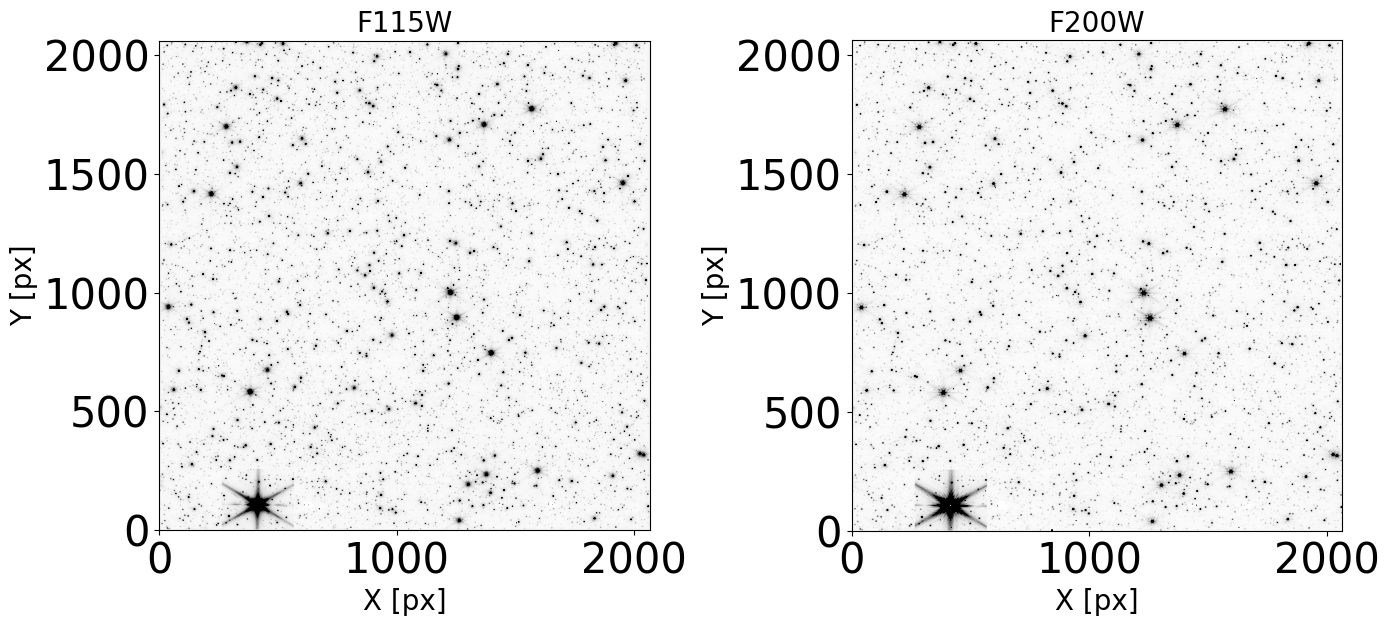

In [6]:
plt.figure(figsize=(14, 14))

for det in dets_short:
    for i, filt in enumerate(filts_short):

        image = fits.open(dict_images[det][filt]['images'][0])
        data_sb = image[1].data

        ax = plt.subplot(1, len(filts_short), i + 1)

        plt.xlabel("X [px]", fontdict=font2)
        plt.ylabel("Y [px]", fontdict=font2)
        plt.title(filt, fontdict=font2)
        norm = simple_norm(data_sb, 'sqrt', percent=99.)

        ax.imshow(data_sb, norm=norm, cmap='Greys')

plt.tight_layout()

## Aperture Photometry

More information on aperture photometry using Photutils can be found here: [Aperture Photometry](https://photutils.readthedocs.io/en/stable/aperture.html)

First, we create a useful dictionary that contains: the sources detected using our finding algorithm ([DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder)), the table with the aperture photometry results, and a final table with positions (both x,y and RA,Dec) instrumental magnitudes ad errors for the detected sources.

In [7]:
dict_aper = {}

for det in dets_short:
    dict_aper.setdefault(det, {})
    for j, filt in enumerate(filts_short):
        dict_aper[det].setdefault(filt, {})

        dict_aper[det][filt]['sources found'] = None
        dict_aper[det][filt]['aperture phot table'] = None
        dict_aper[det][filt]['final aperture phot table'] = None

### 1. Finding sources

[DAOStarFinder](https://photutils.readthedocs.io/en/stable/api/photutils.detection.DAOStarFinder.html#photutils.detection.DAOStarFinder) detects stars in an image using the DAOFIND ([Stetson 1987](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract)) algorithm. DAOFIND searches images for local density maxima that have a peak amplitude greater than `threshold` (approximately; threshold is applied to a convolved image) and have a size and shape similar to the defined 2D Gaussian kernel.

**Note**: we adopted as Background estimator the function [MMMBackground](https://photutils.readthedocs.io/en/stable/api/photutils.background.MMMBackground.html#photutils.background.MMMBackground), which calculates the background in an array using the DAOPHOT MMM algorithm, on the whole image. 

When dealing with a variable background and/or the need to mask the regions where we have no data (for example, if we are analyzing an image with all the 4 NIRCam SW detectors, i.e. containing the chip gaps), we can set `var_bkg` = True and use a more complex algorithm that takes into account those issues.  

Note that the unit of the Level-2 and Level-3 Images from the pipeline is MJy/sr (hence a surface brightness). The actual unit of the image can be checked from the header keyword **BUNIT**. The scalar conversion constant is copied to the header keyword **PHOTMJSR**, which gives the conversion from DN/s to megaJy/steradian. For our analysis we revert back to DN/s.


In [8]:
def find_stars(det='NRCA1', filt='F070W', var_bkg=False):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    image = fits.open(dict_images[det][filt]['images'][i])
    data_sb = image[1].data
    imh = image[1].header

    print("Finding sources on image {number}, filter {f}, detector {d}:".format(number=i + 1, f=filt, d=det))
    print("")
    data = data_sb / imh['PHOTMJSR']
    print("Conversion factor from {units} to DN/S for filter {f}:".format(units=imh['BUNIT'], f=filt), imh['PHOTMJSR'])

    sigma_psf = dict_utils[filt]['psf fwhm']

    print("FWHM for the filter {f}:".format(f=filt), sigma_psf, "px")

    if var_bkg:
        print("Using 2D Background")
        sigma_clip = SigmaClip(sigma=3.)
        coverage_mask = (data == 0)

        bkg = Background2D(data, (25, 25), filter_size=(3, 3), sigma_clip=sigma_clip, bkg_estimator=mmm_bkg,
                           coverage_mask=coverage_mask, fill_value=0.0)

        data_bkgsub = data.copy()
        data_bkgsub = data_bkgsub - bkg.background

        _, _, std = sigma_clipped_stats(data_bkgsub)

    else:

        std = bkgrms(data)
        bkg = mmm_bkg(data)

        data_bkgsub = data.copy()
        data_bkgsub -= bkg

    daofind = DAOStarFinder(threshold=th[j] * std, fwhm=sigma_psf, roundhi=1.0,
                            roundlo=-1.0, sharplo=0.30, sharphi=1.40)

    found_stars = daofind(data_bkgsub)
    dict_aper[det][filt]['sources found'] = found_stars
    print("")
    print("Number of sources found in the image:", len(found_stars))
    print("-------------------------------------")
    print("")

In [9]:
tic = time.perf_counter()

th = [10, 10]  # threshold level for the two filters (length must match number of filters analyzed)

for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):

            find_stars(det=det, filt=filt, var_bkg=False)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

Finding sources on image 1, filter F115W, detector NRCB1:

Conversion factor from MJy/sr to DN/S for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px

Number of sources found in the image: 11034
-------------------------------------

Finding sources on image 1, filter F200W, detector NRCB1:

Conversion factor from MJy/sr to DN/S for filter F200W: 2.564082860946655
FWHM for the filter F200W: 2.141 px

Number of sources found in the image: 12013
-------------------------------------

Elapsed Time for finding stars: 6.812406628000019


### 2. Aperture Photometry

In the function below that allows to perform aperture photometry, we need to specify 4 parameters: the filter (i.e., image) used in the analysis, the aperture radius and the inner and outer radii for the annulus used to determine the local background. Values for the aperture radius and the annulii depend on the adopted filter and the user science case.

Note that Aperture object support multiple positions, allowing to perform photometry in [multiple apertures](https://photutils.readthedocs.io/en/latest/aperture.html#multiple-apertures-at-each-position) at each position. For multiple apertures, the output table column names are appended with the positions index.

In [10]:
def aperture_phot(det=det, filt=filt, radius=[3.5], sky_in=7, sky_out=10):

    positions = np.transpose((dict_aper[det][filt]['sources found']['xcentroid'],
                              dict_aper[det][filt]['sources found']['ycentroid']))

    image = fits.open(dict_images[det][filt]['images'][0])
    data_sb = image[1].data
    imh = image[1].header
    data = data_sb / imh['PHOTMJSR']
    aa = np.argwhere(data < 0)

    for i in np.arange(0, len(aa), 1):
        data[aa[i][0], aa[i][1]] = 0

    error = np.sqrt(data)

    tic = time.perf_counter()

    table_aper = Table()

    for rad in radius:
        print("Performing aperture photometry for filter {1}; radius r = {0} px".format(rad, filt))
        rr = str(rad)
        aperture = CircularAperture(positions, r=rad)
        annulus_aperture = CircularAnnulus(positions, r_in=sky_in, r_out=sky_out)
        annulus_mask = annulus_aperture.to_mask(method='center')

        bkg_median = []
        bkg_stdev = []
        for mask in annulus_mask:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_sigclip, stdev_sigclip = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_sigclip)
            bkg_stdev.append(stdev_sigclip)
        bkg_median = np.array(bkg_median)
        bkg_stdev = np.array(bkg_stdev)

        phot = aperture_photometry(data, aperture, method='exact', error=error)

        phot['annulus_median'] = bkg_median
        phot['aper_bkg'] = bkg_median * aperture.area
        phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

        table_aper.add_column(phot['aperture_sum'], name='aper_sum_' + rr + 'px')
        table_aper.add_column(phot['annulus_median'], name='annulus_median_' + rr + 'px')
        table_aper.add_column(phot['aper_bkg'], name='aper_bkg_' + rr + 'px')
        table_aper.add_column(phot['aper_sum_bkgsub'], name='aper_sum_bkgsub_' + rr + 'px')

        error_poisson = phot['aperture_sum_err']
        error_scatter_sky = aperture.area * bkg_stdev**2
        error_mean_sky = bkg_stdev**2 * aperture.area**2 / annulus_aperture.area

        fluxerr = np.sqrt(error_poisson + error_scatter_sky + error_mean_sky)

        table_aper.add_column(fluxerr, name='flux_err_' + rr + 'px')

        dict_aper[det][filt]['aperture phot table'] = table_aper

    toc = time.perf_counter()
    print("Time Elapsed:", toc - tic)

    return

In [11]:
det = 'NRCB1'
filt1 = 'F115W'
filt2 = 'F200W'

aperture_phot(det=det, filt=filt1, radius=[3.5], sky_in=7, sky_out=10)
aperture_phot(det=det, filt=filt2, radius=[4.0], sky_in=6, sky_out=9)

Performing aperture photometry for filter F115W; radius r = 3.5 px
Time Elapsed: 14.562226738999982
Performing aperture photometry for filter F200W; radius r = 4.0 px
Time Elapsed: 15.135298977000048


### 3. Table with magnitudes and positions

We create the final tables containing positions, magnitudes and errors for each catalog

In [12]:
radii = [3.5, 4.0]

for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):

            radius = str(radii[j])

            image = fits.open(dict_images[det][filt]['images'][0])
            data = image[1].data

            image_model = ImageModel(dict_images[det][filt]['images'][0])

            mask = ((dict_aper[det][filt]['sources found']['xcentroid'] > 0) &
                    (dict_aper[det][filt]['sources found']['xcentroid'] < data.shape[1]) &
                    (dict_aper[det][filt]['sources found']['ycentroid'] > 0) &
                    (dict_aper[det][filt]['sources found']['ycentroid'] < data.shape[0]) &
                    (dict_aper[det][filt]['aperture phot table']['aper_sum_bkgsub_' + radius + 'px'] > 0))

            table_phot = Table()

            table_phot['x'] = dict_aper[det][filt]['sources found']['xcentroid'][mask]
            table_phot['y'] = dict_aper[det][filt]['sources found']['ycentroid'][mask]

            ra, dec = image_model.meta.wcs(table_phot['x'], table_phot['y'])
            table_phot['radec'] = SkyCoord(ra, dec, unit='deg')
            table_phot[filt + '_inst'] = -2.5 * np.log10(dict_aper[det][filt]['aperture phot table']['aper_sum_bkgsub_' + radius + 'px'][mask])
            table_phot['e' + filt + '_inst'] = 1.086 * (dict_aper[det][filt]['aperture phot table']['flux_err_' + radius + 'px'][mask] /
                                                        dict_aper[det][filt]['aperture phot table']['aper_sum_bkgsub_' + radius + 'px'][mask])

            dict_aper[det][filt]['final aperture phot table'] = table_phot

/opt/hostedtoolcache/Python/3.11.6/x64/lib/python3.11/site-packages/asdf/yamlutil.py:282: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.6/x64/lib/python3.11/site-packages/asdf/yamlutil.py:282: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(


### Matched sources Table

We cross-match the catalogs to obtain the single color-magnitude diagram.

Stars from the two filters are associated if the distance between the matches is < 0.5 px. 

In [13]:
max_sep = 0.015 * u.arcsec

idx_inst, d2d_inst, _ = match_coordinates_sky(dict_aper[det][filt1]['final aperture phot table']['radec'],
                                              dict_aper[det][filt2]['final aperture phot table']['radec'])

sep_constraint_inst = d2d_inst < max_sep

matched_sources = Table()

matched_sources['radec'] = dict_aper[det][filt1]['final aperture phot table']['radec'][sep_constraint_inst]
matched_sources['x_' + filt1] = dict_aper[det][filt1]['final aperture phot table']['x'][sep_constraint_inst]
matched_sources['y_' + filt1] = dict_aper[det][filt1]['final aperture phot table']['y'][sep_constraint_inst]
matched_sources['x_' + filt2] = dict_aper[det][filt2]['final aperture phot table']['x'][idx_inst[sep_constraint_inst]]
matched_sources['y_' + filt2] = dict_aper[det][filt2]['final aperture phot table']['y'][idx_inst[sep_constraint_inst]]
matched_sources[filt1 + '_inst'] = dict_aper[det][filt1]['final aperture phot table'][filt1 + '_inst'][sep_constraint_inst]
matched_sources['e' + filt1 + '_inst'] = dict_aper[det][filt1]['final aperture phot table']['e' + filt1 + '_inst'][sep_constraint_inst]
matched_sources[filt2 + '_inst'] = dict_aper[det][filt2]['final aperture phot table'][filt2 + '_inst'][idx_inst[sep_constraint_inst]]
matched_sources['e' + filt2 + '_inst'] = dict_aper[det][filt2]['final aperture phot table']['e' + filt2 + '_inst'][idx_inst[sep_constraint_inst]]

## Instrumental Color-Magnitude Diagram and Errors

In the error plots, the grey dots represent measures all the detections in each filter, whereas the black dots represent the detections matched between the two catalogs.

2023-10-18 15:32:17,969 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:17,970 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,040 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,111 - stpipe - WARNING - findfont: Font family ['helvetica'] not found. Falling back to DejaVu Sans.
2023-10-18 15:32:18,199 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,278 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,315 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,355 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,417 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,808 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:18,810 - stpipe - WARNING - findfont: Font family 'h

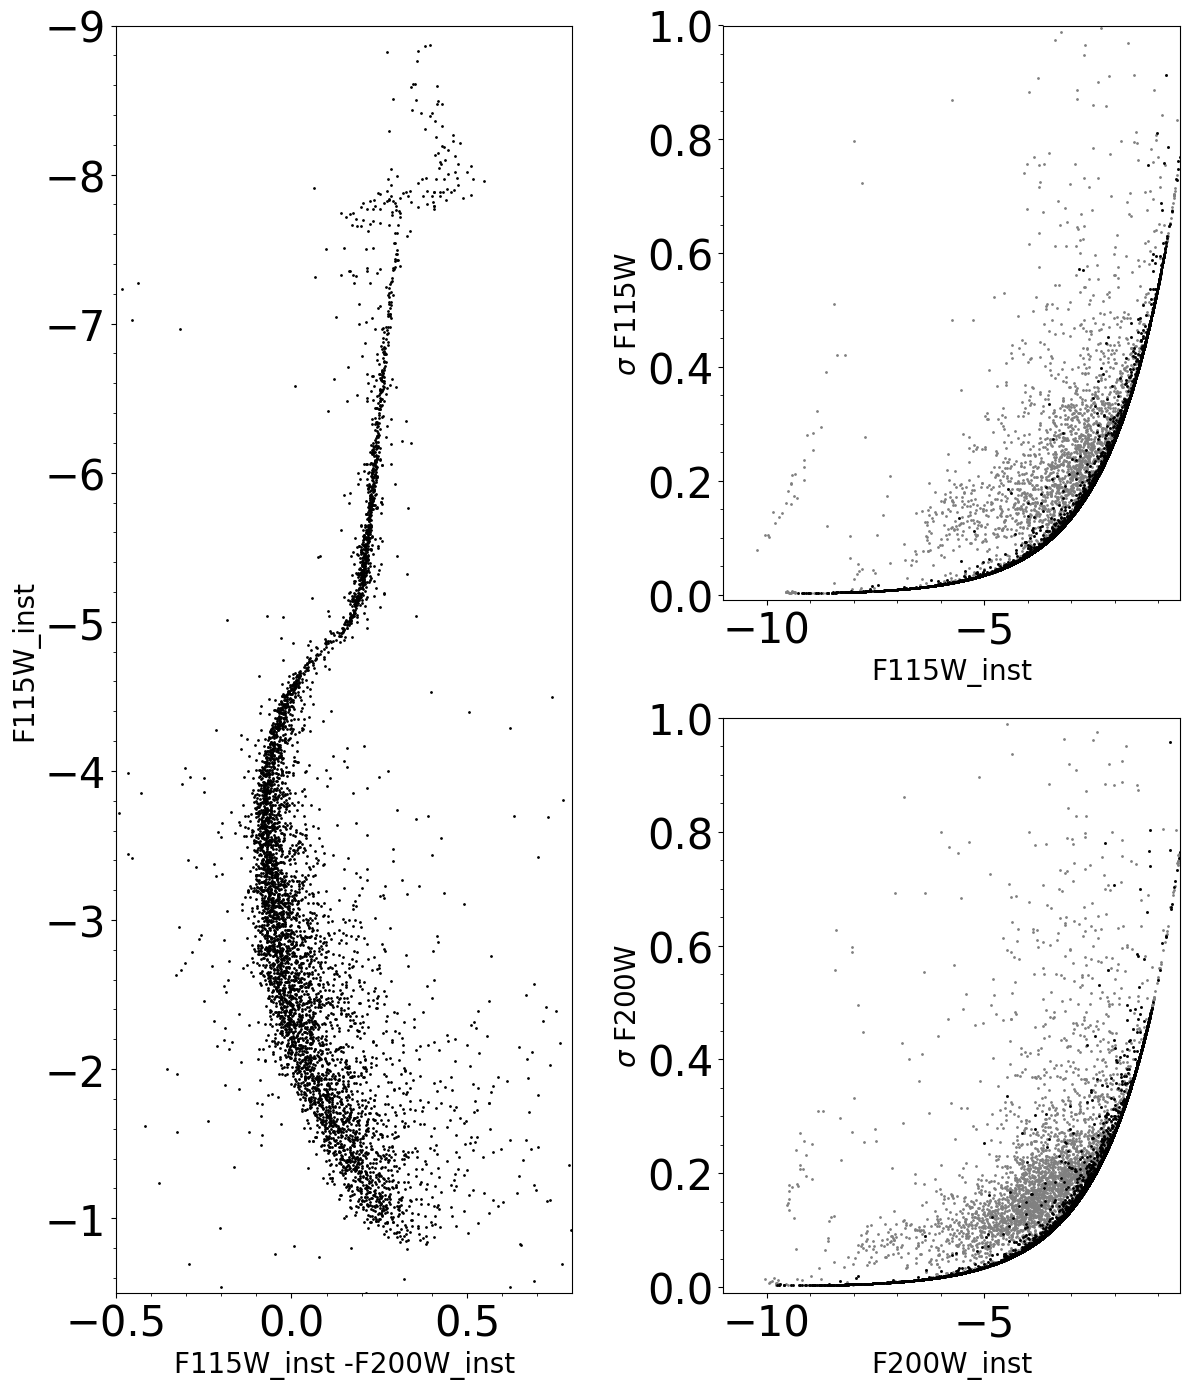

In [14]:
plt.figure(figsize=(12, 14))
plt.clf()

ax1 = plt.subplot(1, 2, 1)

ax1.set_xlabel(filt1 + '_inst -' + filt2 + '_inst', fontdict=font2)
ax1.set_ylabel(filt1 + '_inst', fontdict=font2)

xlim0 = -0.5
xlim1 = 0.8
ylim0 = -0.5
ylim1 = -9

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(matched_sources[filt1 + '_inst'] - matched_sources[filt2 + '_inst'], matched_sources[filt1 + '_inst'],
            s=1, color='k')

ax2 = plt.subplot(2, 2, 2)

ax2.set_xlabel(filt1 + '_inst', fontdict=font2)
ax2.set_ylabel('$\sigma$ ' + filt1, fontdict=font2)

xlim0 = -11
xlim1 = -0.5
ylim0 = -0.01
ylim1 = 1

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(dict_aper[det][filt1]['final aperture phot table'][filt1 + '_inst'],
            dict_aper[det][filt1]['final aperture phot table']['e' + filt1 + '_inst'], s=1, c='gray')

ax2.scatter(matched_sources[filt1 + '_inst'], matched_sources['e' + filt1 + '_inst'], s=1, c='k')

ax3 = plt.subplot(2, 2, 4)

ax3.set_xlabel(filt2 + '_inst', fontdict=font2)
ax3.set_ylabel('$\sigma$ ' + filt2, fontdict=font2)

ax3.set_xlim(xlim0, xlim1)
ax3.set_ylim(ylim0, ylim1)

ax3.xaxis.set_major_locator(ticker.AutoLocator())
ax3.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax3.yaxis.set_major_locator(ticker.AutoLocator())
ax3.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax3.scatter(dict_aper[det][filt2]['final aperture phot table'][filt2 + '_inst'],
            dict_aper[det][filt2]['final aperture phot table']['e' + filt2 + '_inst'], s=1, c='gray')

ax3.scatter(matched_sources[filt2 + '_inst'], matched_sources['e' + filt2 + '_inst'], s=1, c='k')

plt.tight_layout()

## Photometric Zeropoints

To obtain the final calibrated color-magnitude diagram, we need to calculate the photometric zeropoints. Hence we need to perform aperture photometry on the images using an aperture radius correspondent to a value of the encircled energy (EE), apply the appropriate aperture correction for the finite aperture adopted (the values provided in the dictionary above are for an infinite aperture) and then compare it with the aperture photometry determined above. Hence, we can summarize the steps as follows:

* perform aperture photometry using an appropriate radius (equivalent to a certain value of the EE) 
* apply appropriate aperture correction
* apply tabulated zeropoint
* cross-match with aperture photometry

**Note**: to select the stars for the zeropoint calculation, we can select a subsample using the CMD as a reference, or perform aperture photometry on a sample of bright isolated stars. To change the method used we can set `sample` = cmd or `sample` = found, respectively.

### Load aperture correction table

**Note**: these values are obtained from the study of the synthetic WebbPSF PSFs. They will be updated once we have in-flight measures.

In [15]:
if os.path.isfile('./aperture_correction_table.txt'):
    ap_tab = './aperture_correction_table.txt'
else:
    print("Downloading the aperture correction table")

    boxlink_apcorr_table = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/aperture_correction_table.txt'
    boxfile_apcorr_table = './aperture_correction_table.txt'
    urllib.request.urlretrieve(boxlink_apcorr_table, boxfile_apcorr_table)
    ap_tab = './aperture_correction_table.txt'

aper_table = pd.read_csv(ap_tab, header=None, sep='\s+', index_col=0,
                         names=['filter', 'pupil', 'wave', 'r10', 'r20', 'r30', 'r40', 'r50', 'r60', 'r70', 'r80',
                                'r85', 'r90', 'sky_flux_px', 'apcorr10', 'apcorr20', 'apcorr30', 'apcorr40',
                                'apcorr50', 'apcorr60', 'apcorr70', 'apcorr80', 'apcorr85', 'apcorr90', 'sky_in',
                                'sky_out'], comment='#', skiprows=0, usecols=range(0, 26))
aper_table.head()

,pupil,wave,r10,r20,r30,r40,r50,r60,r70,r80,...,apcorr30,apcorr40,apcorr50,apcorr60,apcorr70,apcorr80,apcorr85,apcorr90,sky_in,sky_out
filter,,,,,,,,,,,,,,,,,,,,,
F070W,CLEAR,70,0.451,0.869,1.263,1.648,2.191,3.266,5.176,7.292,...,3.3651,2.5305,2.0347,1.7210,1.5328,1.4174,1.4174,1.5880,7.292,9.017
F090W,CLEAR,90,0.408,0.638,0.992,1.503,1.925,2.549,4.162,7.480,...,3.3519,2.5241,2.0253,1.6977,1.4908,1.4173,1.4173,1.6016,7.480,9.251
F115W,CLEAR,115,0.374,0.571,0.778,1.036,1.768,2.324,3.287,6.829,...,3.3404,2.5070,2.0131,1.6825,1.4520,1.3310,1.3310,1.3964,6.829,9.723
F140M,CLEAR,140,0.414,0.617,0.801,1.031,1.367,2.434,3.118,6.031,...,3.3397,2.5060,2.0067,1.6815,1.4465,1.3029,1.3029,1.3794,6.031,9.608
F150W,CLEAR,150,0.431,0.639,0.826,1.065,1.360,2.476,3.199,6.082,...,3.3405,2.5067,2.0070,1.6828,1.4485,1.3068,1.3068,1.4188,6.082,9.496


### 1a. Subsample using the CMD as a reference

**Note**: if the users want to impose a more stringent condition, selecting within the sub-sample of stars the ones with no neighbour closer than X pixel, where X can be fixed appropriately, it can be done setting `dist_sel` = True.

The limiting magnitudes and the maximum distance to the closest neighbour depend on the user science case (i.e.; number of stars in the field of view, crowding, number of bright sources, etc.) and must be modified accordingly. 

The final table `xy_cmd` contain the positions (X,Y) of the selected stars in the two filters.

In [16]:
xy_cmd = Table()

mag_lim_bright = -7.0
mag_lim_faint = -4.5

mask_xy = ((matched_sources[filt1 + '_inst'] < mag_lim_faint) & (matched_sources[filt1 + '_inst'] > mag_lim_bright))

xy_cmd['x_' + filt1] = matched_sources['x_' + filt1][mask_xy]
xy_cmd['y_' + filt1] = matched_sources['y_' + filt1][mask_xy]
xy_cmd['x_' + filt2] = matched_sources['x_' + filt2][mask_xy]
xy_cmd['y_' + filt2] = matched_sources['y_' + filt2][mask_xy]

print("Number of stars selected from CMD:", len(xy_cmd))

dist_sel = False

if dist_sel:

    print("")
    print("Calculating closest neigbhour distance")

    d_filt1 = []
    d_filt2 = []
    min_sep_filt1 = 10
    min_sep_filt2 = 10

    for i, j in zip(xy_cmd['x_' + filt1], xy_cmd['y_' + filt1]):

        sep = []
        dist = np.sqrt((dict_aper[det][filt1]['sources found']['xcentroid'] - i)**2 + (dict_aper[det][filt1]['sources found']['ycentroid'] - j)**2)
        sep = np.sort(dist)[1:2][0]
        d_filt1.append(sep)

    for i, j in zip(xy_cmd['x_' + filt2], xy_cmd['y_' + filt2]):

        sep = []
        dist = np.sqrt((dict_aper[det][filt2]['sources found']['xcentroid'] - i)**2 + (dict_aper[det][filt2]['sources found']['ycentroid'] - j)**2)
        sep = np.sort(dist)[1:2][0]
        d_filt2.append(sep)

    xy_cmd['min distance ' + filt1] = d_filt1
    xy_cmd['min distance ' + filt2] = d_filt2

    mask_dist = ((xy_cmd['min distance ' + filt1] > min_sep_filt1) & (xy_cmd['min distance ' + filt2] > min_sep_filt2))

    xy_cmd = xy_cmd[mask_dist]

    print("")
    print("Minimum distance required for filter {f}:".format(f=filt1), min_sep_filt1, "px")
    print("Minimum distance required for filter {f}:".format(f=filt2), min_sep_filt2, "px")
    print("")
    print("Number of stars selected from CMD including distance constraints:", len(xy_cmd))

Number of stars selected from CMD: 896


As we have done previously, we create a dictionary that contains the tables with the derived aperture photometry (for the bright stars) for each image.

In [17]:
dict_zp = {}

for det in dets_short:
    dict_zp.setdefault(det, {})
    for j, filt in enumerate(filts_short):

        dict_zp[det].setdefault(filt, {})

        dict_zp[det][filt]['sources found'] = None
        dict_zp[det][filt]['aperture phot table'] = None
        dict_zp[det][filt]['final aperture phot table'] = None

In [18]:
def find_bright_stars(det='NRCA1', filt='F070W', var_bkg=False, dist_sel=False):

    bkgrms = MADStdBackgroundRMS()
    mmm_bkg = MMMBackground()

    image = fits.open(dict_images[det][filt]['images'][i])
    data_sb = image[1].data
    imh = image[1].header

    print("Finding sources on image {number}, filter {f}, detector {d}:".format(number=i + 1, f=filt, d=det))
    print("")
    data = data_sb / imh['PHOTMJSR']
    print("Conversion factor from {units} to DN/s for filter {f}:".format(units=imh['BUNIT'], f=filt), imh['PHOTMJSR'])

    sigma_psf = dict_utils[filt]['psf fwhm']

    print("FWHM for the filter {f}:".format(f=filt), sigma_psf, "px")

    if var_bkg:
        print("Using 2D Background")
        sigma_clip = SigmaClip(sigma=3.)
        coverage_mask = (data == 0)

        bkg = Background2D(data, (25, 25), filter_size=(3, 3), sigma_clip=sigma_clip,
                           bkg_estimator=mmm_bkg, coverage_mask=coverage_mask, fill_value=0.0)

        data_bkgsub = data.copy()
        data_bkgsub = data_bkgsub - bkg.background

        _, _, std = sigma_clipped_stats(data_bkgsub)

    else:

        std = bkgrms(data)
        bkg = mmm_bkg(data)

        data_bkgsub = data.copy()
        data_bkgsub -= bkg

    daofind = DAOStarFinder(threshold=th[j] * std, fwhm=sigma_psf, roundhi=1.0, roundlo=-1.0,
                            sharplo=0.30, sharphi=1.40)

    zp_stars = daofind(data_bkgsub)

    dict_zp[det][filt]['sources found'] = zp_stars

    if dist_sel:

        print("")
        print("Calculating closest neigbhour distance")

        d = []

        for xx, yy in zip(zp_stars['xcentroid'], zp_stars['ycentroid']):

            sep = []
            dist = np.sqrt((dict_aper[det][filt]['sources found']['xcentroid'] - xx)**2 +
                           (dict_aper[det][filt]['sources found']['ycentroid'] - yy)**2)
            sep = np.sort(dist)[1:2][0]
            d.append(sep)

        zp_stars['min distance'] = d
        mask_dist = (zp_stars['min distance'] > min_sep[j])

        zp_stars = zp_stars[mask_dist]

        dict_zp[det][filt]['sources found'] = zp_stars

        print("Minimum distance required:", min_sep[j], "px")
        print("")
        print("Number of bright isolated sources found in the image:", len(zp_stars))
        print("-----------------------------------------------------")
        print("")
    else:
        print("")
        print("Number of bright sources found in the image:", len(zp_stars))
        print("--------------------------------------------")
        print("")

The threshold and the maximum distance to the closest neighbour depend on the user science case (i.e.; number of stars in the field of view, crowding, number of bright sources, etc.) and must be modified accordingly. 

In [19]:
tic = time.perf_counter()

th = [700, 500]  # threshold level for the two filters (length must match number of filters analyzed)
min_sep = [10, 10]  # minimum separation acceptable for zp stars from closest neighbour

for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):

            find_bright_stars(det=det, filt=filt, var_bkg=False, dist_sel=False)

toc = time.perf_counter()

print("Elapsed Time for finding stars:", toc - tic)

Finding sources on image 1, filter F115W, detector NRCB1:

Conversion factor from MJy/sr to DN/s for filter F115W: 3.821892261505127
FWHM for the filter F115W: 1.298 px

Number of bright sources found in the image: 1299
--------------------------------------------

Finding sources on image 1, filter F200W, detector NRCB1:

Conversion factor from MJy/sr to DN/s for filter F200W: 2.564082860946655
FWHM for the filter F200W: 2.141 px

Number of bright sources found in the image: 1479
--------------------------------------------

Elapsed Time for finding stars: 4.083447362000015


### Aperture Photometry on the bright isolated stars

To select the sample of stars that we want to use in the aperture photometry, modify the `sample` keyword, using *cmd* or *found*.  

In [20]:
def aperture_phot_zp(det=det, filt=filt, sample='found'):

    radii = [aper_table.loc[filt]['r70']]

    ees = '70'.split()
    ee_radii = dict(zip(ees, radii))

    if sample == 'found':

        positions = np.transpose((dict_zp[det][filt]['sources found']['xcentroid'],
                                  dict_zp[det][filt]['sources found']['ycentroid']))

    if sample == 'cmd':

        positions = np.transpose((xy_cmd['x_' + filt], xy_cmd['y_' + filt]))

    image = fits.open(dict_images[det][filt]['images'][0])
    data_sb = image[1].data
    imh = image[1].header
    data = data_sb / imh['PHOTMJSR']
    aa = np.argwhere(data < 0)

    for i in np.arange(0, len(aa), 1):
        data[aa[i][0], aa[i][1]] = 0

    # sky from the aperture correction table:

    sky = {"sky_in": aper_table.loc[filt]['r80'], "sky_out": aper_table.loc[filt]['r85']}

    tic = time.perf_counter()

    table_zp = Table()

    for ee, radius in ee_radii.items():
        print("Performing aperture photometry for radius equivalent to EE = {0}% for filter {1}".format(ee, filt))
        aperture = CircularAperture(positions, r=radius)
        annulus_aperture = CircularAnnulus(positions, r_in=sky["sky_in"], r_out=sky["sky_out"])
        annulus_mask = annulus_aperture.to_mask(method='center')

        bkg_median = []
        for mask in annulus_mask:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_sigclip)
        bkg_median = np.array(bkg_median)

        phot = aperture_photometry(data, aperture, method='exact')
        phot['annulus_median'] = bkg_median
        phot['aper_bkg'] = bkg_median * aperture.area
        phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']

        apcorr = [aper_table.loc[filt]['apcorr70']]

        phot['aper_sum_corrected'] = phot['aper_sum_bkgsub'] * apcorr

        table_zp.add_column(phot['aperture_sum'], name='aper_sum_' + ee)
        table_zp.add_column(phot['annulus_median'], name='annulus_median_' + ee)
        table_zp.add_column(phot['aper_bkg'], name='aper_bkg_ee_' + ee)
        table_zp.add_column(phot['aper_sum_bkgsub'], name='aper_sum_bkgsub_' + ee)
        table_zp.add_column(phot['aper_sum_corrected'], name='aper_sum_corrected_' + ee + '_' + filt)

        dict_zp[det][filt]['aperture phot table'] = table_zp

    toc = time.perf_counter()
    print("Time Elapsed:", toc - tic)

    return

In [21]:
aperture_phot_zp(det=det, filt=filt1, sample='cmd')
aperture_phot_zp(det=det, filt=filt2, sample='cmd')

Performing aperture photometry for radius equivalent to EE = 70% for filter F115W
Time Elapsed: 1.0666929390000064
Performing aperture photometry for radius equivalent to EE = 70% for filter F200W
Time Elapsed: 1.0374323180000147


In [22]:
ee = '70'
sample = 'cmd'

for det in dets_short:
    for j, filt in enumerate(filts_short):
        for i in np.arange(0, len(dict_images[det][filt]['images']), 1):

            image = fits.open(dict_images[det][filt]['images'][0])
            data = image[1].data

            image_model = ImageModel(dict_images[det][filt]['images'][0])
            table_zp_mag = Table()

            if sample == 'found':

                mask = ((dict_zp[det][filt]['sources found']['xcentroid'] > 0) &
                        (dict_zp[det][filt]['sources found']['xcentroid'] < data.shape[1]) &
                        (dict_zp[det][filt]['sources found']['ycentroid'] > 0) &
                        (dict_zp[det][filt]['sources found']['ycentroid'] < data.shape[0]) &
                        (dict_zp[det][filt]['aperture phot table']['aper_sum_corrected_' + ee + '_' + filt] > 0))

                table_zp_mag['x'] = dict_zp[det][filt]['sources found']['xcentroid'][mask]
                table_zp_mag['y'] = dict_zp[det][filt]['sources found']['ycentroid'][mask]

                ra, dec = image_model.meta.wcs(table_zp_mag['x'], table_zp_mag['y'])
                table_zp_mag['radec'] = SkyCoord(ra, dec, unit='deg')
                table_zp_mag[filt + '_inst'] = -2.5 * np.log10(dict_zp[det][filt]['aperture phot table']['aper_sum_corrected_' + ee + '_' + filt][mask])
                table_zp_mag[filt + '_zp'] = table_zp_mag[filt + '_inst'] + dict_utils[filt]['VegaMAG zp modB']

                dict_zp[det][filt]['final aperture phot table'] = table_zp_mag

            if sample == 'cmd':

                mask = ((dict_zp[det][filt]['aperture phot table']['aper_sum_corrected_' + ee + '_' + filt] > 0))

                table_zp_mag['x'] = xy_cmd['x_' + filt][mask]
                table_zp_mag['y'] = xy_cmd['y_' + filt][mask]
                ra, dec = image_model.meta.wcs(table_zp_mag['x'], table_zp_mag['y'])
                table_zp_mag['radec'] = SkyCoord(ra, dec, unit='deg')

                table_zp_mag[filt + '_inst'] = -2.5 * np.log10(dict_zp[det][filt]['aperture phot table']['aper_sum_corrected_' + ee + '_' + filt][mask])
                table_zp_mag[filt + '_zp'] = table_zp_mag[filt + '_inst'] + dict_utils[filt]['VegaMAG zp modB']

                dict_zp[det][filt]['final aperture phot table'] = table_zp_mag

/opt/hostedtoolcache/Python/3.11.6/x64/lib/python3.11/site-packages/asdf/yamlutil.py:282: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(
/opt/hostedtoolcache/Python/3.11.6/x64/lib/python3.11/site-packages/asdf/yamlutil.py:282: AsdfConversionWarning: A ndarray subclass (<class 'astropy.io.fits.fitsrec.FITS_rec'>) was converted as a ndarray. This behavior will be removed from a future version of ASDF. See https://asdf.readthedocs.io/en/latest/asdf/config.html#convert-unknown-ndarray-subclasses
  warnings.warn(


### Derive Zeropoints

2023-10-18 15:32:34,586 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,587 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,615 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,686 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,713 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,768 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,786 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,825 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:34,841 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:35,116 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18 15:32:35,118 - stpipe - WARNING - findfont: Font family 'helvetica' not found.
2023-10-18

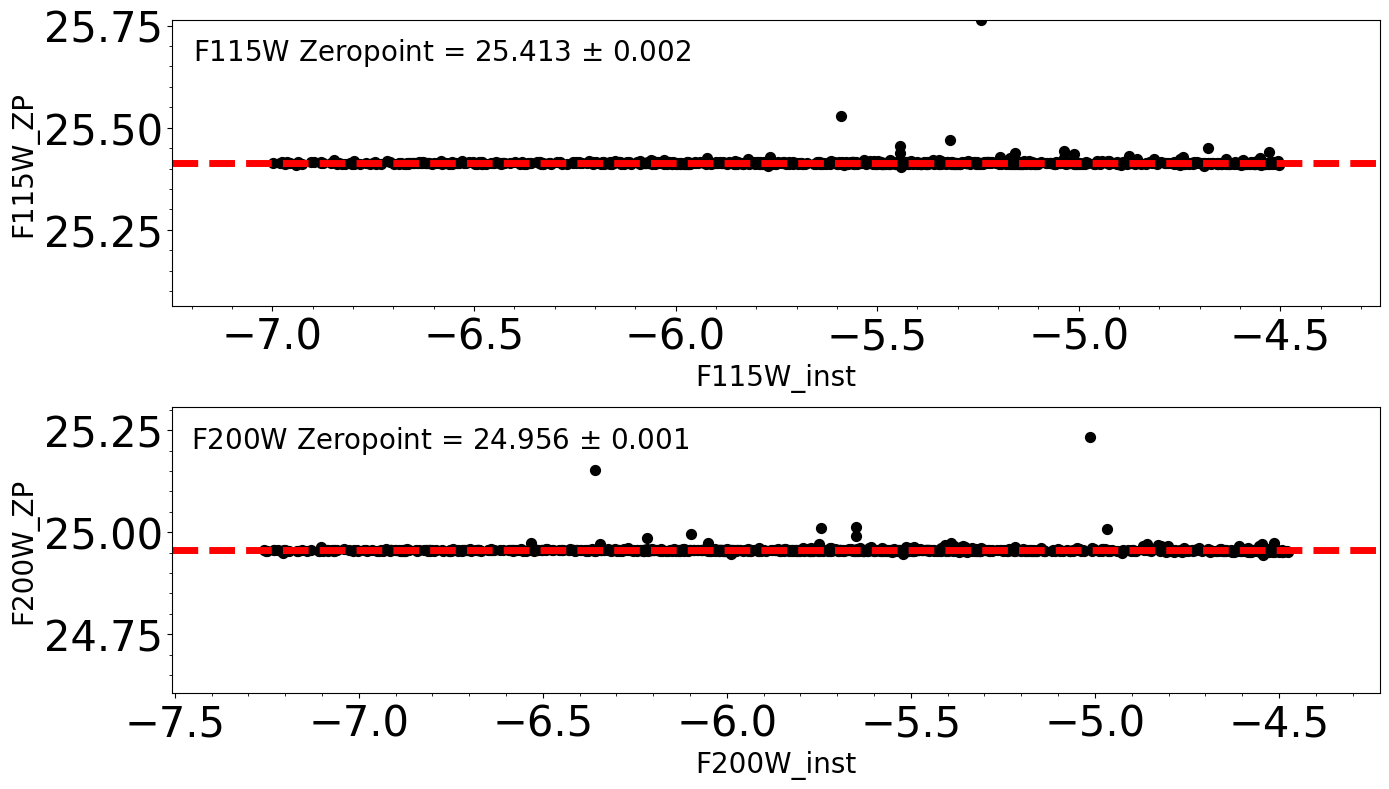

In [23]:
plt.figure(figsize=(14, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel(filt1 + '_inst', fontdict=font2)
ax1.set_ylabel(filt1 + '_ZP', fontdict=font2)

idx_zp_1, d2d_zp_1, _ = match_coordinates_sky(dict_zp[det][filt1]['final aperture phot table']['radec'],
                                              dict_aper[det][filt1]['final aperture phot table']['radec'])

sep_constraint_zp_1 = d2d_zp_1 < max_sep

f115w_apZP_matched = np.array(dict_zp[det][filt1]['final aperture phot table'][filt1 + '_zp'][sep_constraint_zp_1])
f115w_ap_matched = np.array(dict_aper[det][filt1]['final aperture phot table'][filt1 + '_inst'][idx_zp_1[sep_constraint_zp_1]])

diff_f115w = f115w_apZP_matched - f115w_ap_matched
_, zp_f115w, zp_sigma_f115w = sigma_clipped_stats(diff_f115w)

xlim0 = np.min(f115w_ap_matched) - 0.25
xlim1 = np.max(f115w_ap_matched) + 0.25
ylim0 = np.mean(diff_f115w) - 0.35
ylim1 = np.mean(diff_f115w) + 0.35

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(f115w_ap_matched, diff_f115w, s=50, color='k')
ax1.plot([xlim0, xlim1], [zp_f115w, zp_f115w], color='r', lw=5, ls='--')
ax1.text(xlim0 + 0.05, ylim1 - 0.1, filt1 + ' Zeropoint = %5.3f $\pm $ %5.3f' % (zp_f115w, zp_sigma_f115w),
         color='k', fontdict=font2)

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel(filt2 + '_inst', fontdict=font2)
ax2.set_ylabel(filt2 + '_ZP', fontdict=font2)

idx_zp_2, d2d_zp_2, _ = match_coordinates_sky(dict_zp[det][filt2]['final aperture phot table']['radec'],
                                              dict_aper[det][filt2]['final aperture phot table']['radec'])

sep_constraint_zp_2 = d2d_zp_2 < max_sep

f200w_apZP_matched = np.array(dict_zp[det][filt2]['final aperture phot table'][filt2 + '_zp'][sep_constraint_zp_2])
f200w_ap_matched = np.array(dict_aper[det][filt2]['final aperture phot table'][filt2 + '_inst'][idx_zp_2[sep_constraint_zp_2]])

diff_f200w = f200w_apZP_matched - f200w_ap_matched
_, zp_f200w, zp_sigma_f200w = sigma_clipped_stats(diff_f200w)

xlim0 = np.min(f200w_ap_matched) - 0.25
xlim1 = np.max(f200w_ap_matched) + 0.25
ylim0 = np.mean(diff_f200w) - 0.35 
ylim1 = np.mean(diff_f200w) + 0.35

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(f200w_ap_matched, diff_f200w, s=50, color='k')
ax2.plot([xlim0, xlim1], [zp_f200w, zp_f200w], color='r', lw=5, ls='--')
ax2.text(xlim0 + 0.05, ylim1 - 0.1, filt2 + ' Zeropoint = %5.3f $\pm$ %5.3f' % (zp_f200w, zp_sigma_f200w), 
         color='k', fontdict=font2)

plt.tight_layout()

## Import Input catalog

In [24]:
if os.path.isfile('./pointsource.cat'):
    input_cat = './pointsource.cat'

else:
    
    print("Downloading input pointsource catalog")

    boxlink_input_cat = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/stellar_photometry/pointsource.cat'
    boxfile_input_cat = './pointsource.cat'
    urllib.request.urlretrieve(boxlink_input_cat, boxfile_input_cat)
    input_cat = './pointsource.cat'

cat = pd.read_csv(input_cat, header=None, sep='\s+', names=['ra_in', 'dec_in', 'f070w_in', 'f115w_in',
                                                            'f200w_in', 'f277w_in', 'f356w_in', 'f444w_in'],
                  comment='#', skiprows=7, usecols=range(0, 8))

cat.head()


,ra_in,dec_in,f070w_in,f115w_in,f200w_in,f277w_in,f356w_in,f444w_in
0,80.386396,-69.468909,21.34469,20.75333,20.25038,20.23116,20.20482,20.23520
1,80.385588,-69.469201,20.12613,19.33709,18.64676,18.63521,18.58796,18.64291
2,80.380365,-69.470930,21.52160,20.98518,20.53500,20.51410,20.49231,20.51610
3,80.388130,-69.468453,20.82162,20.06542,19.40552,19.39262,19.34927,19.40018
4,80.388936,-69.468196,21.47197,20.92519,20.46507,20.44447,20.42186,20.44687


In [25]:
lim_ra_min = np.min(dict_aper[det][filt1]['final aperture phot table']['radec'].ra)
lim_ra_max = np.max(dict_aper[det][filt1]['final aperture phot table']['radec'].ra)
lim_dec_min = np.min(dict_aper[det][filt1]['final aperture phot table']['radec'].dec)
lim_dec_max = np.max(dict_aper[det][filt1]['final aperture phot table']['radec'].dec)

cat_sel = cat[(cat['ra_in'] > lim_ra_min) & (cat['ra_in'] < lim_ra_max) & (cat['dec_in'] > lim_dec_min)
              & (cat['dec_in'] < lim_dec_max)]

## Calibrated Color-Magnitude Diagram

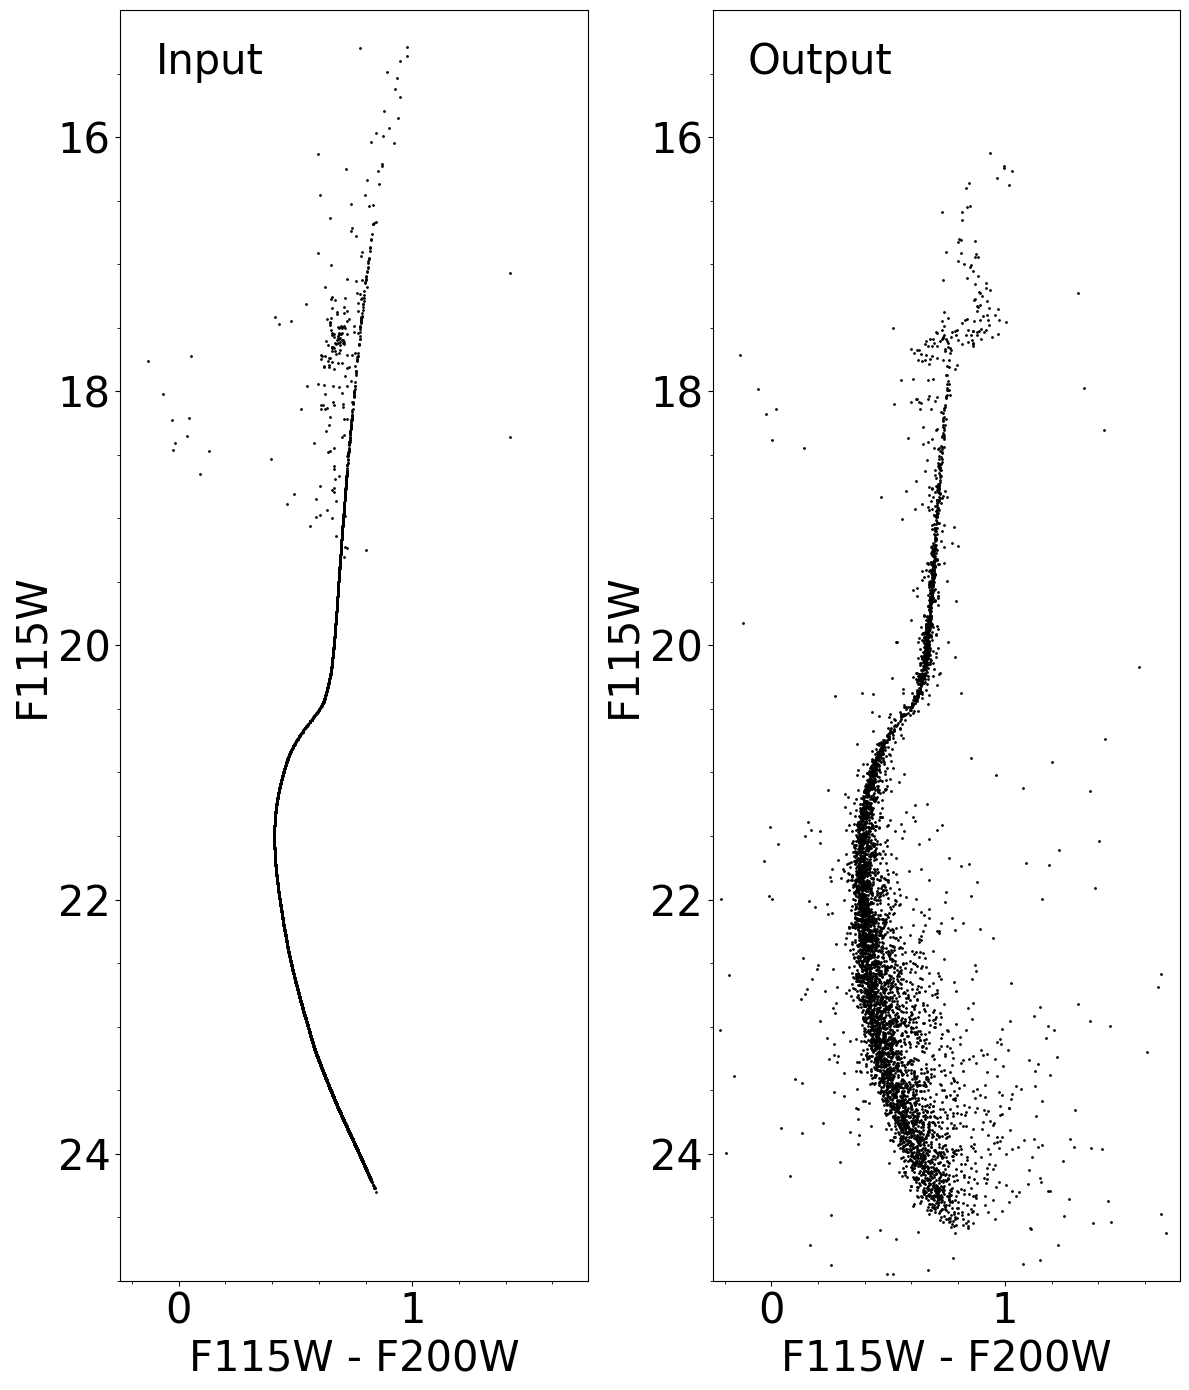

In [26]:
plt.figure(figsize=(12, 14))
plt.clf()

font2 = {'size': '30'}

ax1 = plt.subplot(1, 2, 1)

mag1_in = np.array(cat_sel['f115w_in'])
mag2_in = np.array(cat_sel['f200w_in'])
diff_in = mag1_in - mag2_in

xlim0 = -0.25
xlim1 = 1.75
ylim0 = 25
ylim1 = 15 
ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(mag1_in - mag2_in, mag1_in, s=1, color='k')

ax1.set_xlabel(filt1 + ' - ' + filt2, fontdict=font2)
ax1.set_ylabel(filt1, fontdict=font2)
ax1.text(xlim0 + 0.15, 15.5, "Input", fontdict=font2)

ax2 = plt.subplot(1, 2, 2)

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

f115w = matched_sources[filt1 + '_inst'] + zp_f115w 
f200w = matched_sources[filt2 + '_inst'] + zp_f200w

maglim = np.arange(18, 25, 1)
mags = []
errs_mag = []
errs_col = []

for i in np.arange(0, len(maglim) - 1, 1):
    mag = (maglim[i] + maglim[i + 1]) / 2
    err_mag1 = matched_sources['e' + filt1 + '_inst'][(f115w > maglim[i]) & (f115w < maglim[i + 1])]
    err_mag2 = matched_sources['e' + filt2 + '_inst'][(f115w > maglim[i]) & (f115w < maglim[i + 1])]
    err_mag = np.mean(err_mag1[i])
    err_temp = np.sqrt(err_mag1**2 + err_mag2**2)
    err_col = np.mean(err_temp[i])

    errs_mag.append(err_mag)                  
    errs_col.append(err_col)
    mags.append(mag)

col = [0] * (len(maglim) - 1)

# ax2.errorbar(col, mags, yerr=errs_mag, xerr=errs_col, fmt='o', color = 'k')
    
ax2.scatter(f115w - f200w, f115w, s=1, color='k')
ax2.text(xlim0 + 0.15, 15.5, "Output", fontdict=font2)

ax2.set_xlabel(filt1 + ' - ' + filt2, fontdict=font2)
ax2.set_ylabel(filt1, fontdict=font2)

plt.tight_layout()

## Comparison between input and output photometry

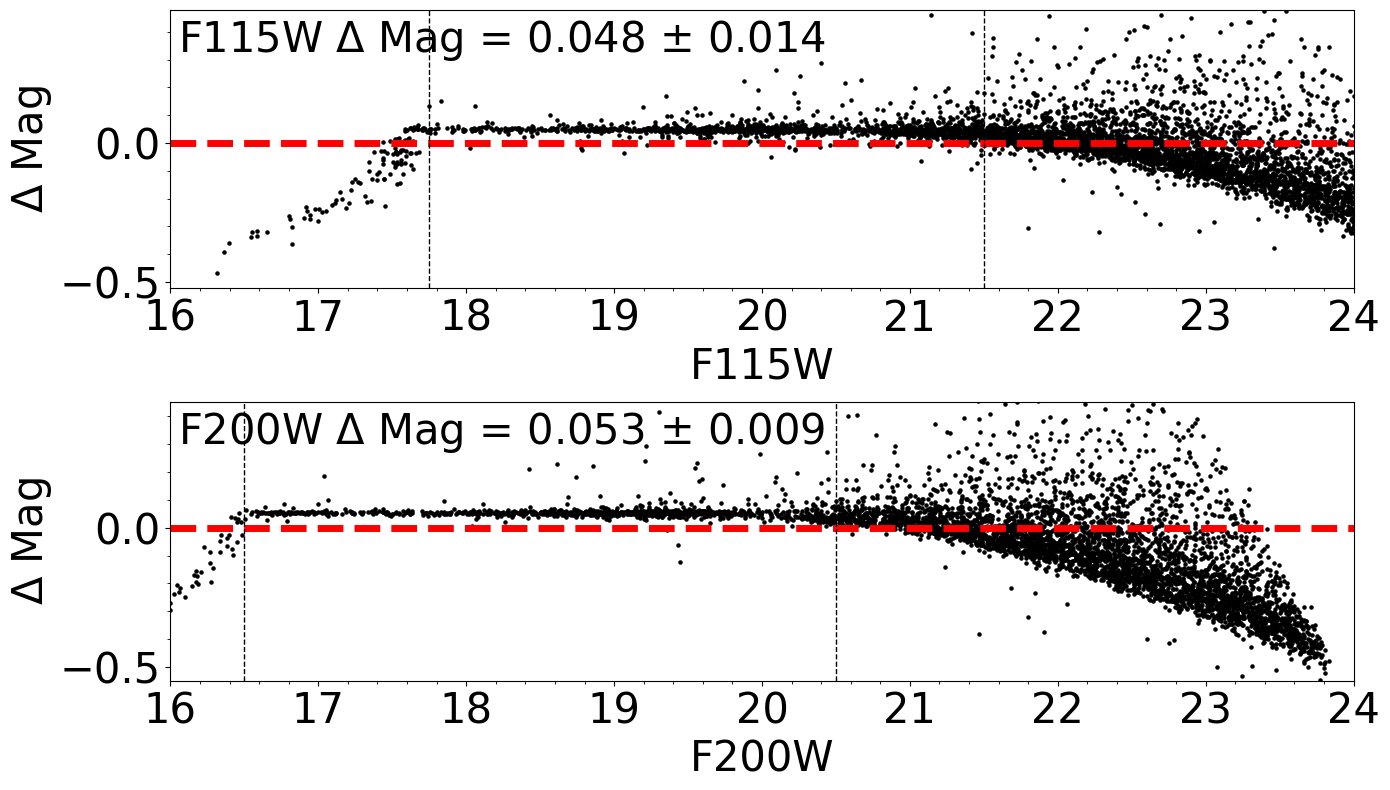

In [27]:
plt.figure(figsize=(14, 8))
plt.clf()

ax1 = plt.subplot(2, 1, 1)

ax1.set_xlabel(filt1, fontdict=font2)
ax1.set_ylabel('$\Delta$ Mag', fontdict=font2)

radec_input = SkyCoord(cat_sel['ra_in'], cat_sel['dec_in'], unit='deg')

idx_f115w_cfr, d2d_f115w_cfr, _ = match_coordinates_sky(radec_input, matched_sources['radec'])

sep_f115w_cfr = d2d_f115w_cfr < max_sep

f115w_inp_cfr = np.array(cat_sel['f115w_in'][sep_f115w_cfr])
f115w_ap_cfr = np.array(f115w[idx_f115w_cfr[sep_f115w_cfr]])

diff_f115w_cfr = f115w_inp_cfr - f115w_ap_cfr
diff_f115w_cfr_sel = (f115w_inp_cfr - f115w_ap_cfr)[(f115w_ap_cfr > 17.75) & (f115w_ap_cfr < 21.5)]

_, med_diff_f115w_cfr, sig_diff_f115w_cfr = sigma_clipped_stats(diff_f115w_cfr_sel)

xlim0 = 16
xlim1 = 24
ylim0 = np.mean(diff_f115w_cfr) - 0.5
ylim1 = np.mean(diff_f115w_cfr) + 0.5

ax1.set_xlim(xlim0, xlim1)
ax1.set_ylim(ylim0, ylim1)

ax1.xaxis.set_major_locator(ticker.AutoLocator())
ax1.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax1.yaxis.set_major_locator(ticker.AutoLocator())
ax1.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax1.scatter(f115w_ap_cfr, diff_f115w_cfr, s=5, color='k')
ax1.plot([xlim0, xlim1], [0, 0], color='r', lw=5, ls='--')
ax1.plot([17.75, 17.75], [ylim0, ylim1], color='k', lw=1, ls='--')
ax1.plot([21.5, 21.5], [ylim0, ylim1], color='k', lw=1, ls='--')

ax1.text(xlim0 + 0.05, ylim1 - 0.15, filt1 + ' $\Delta$ Mag = %5.3f $\pm$ %5.3f'
         % (med_diff_f115w_cfr, sig_diff_f115w_cfr), color='k', fontdict=font2)

ax2 = plt.subplot(2, 1, 2)

ax2.set_xlabel(filt2, fontdict=font2)
ax2.set_ylabel('$\Delta$ Mag', fontdict=font2)

idx_f200w_cfr, d2d_f200w_cfr, _ = match_coordinates_sky(radec_input, matched_sources['radec'])

sep_f200w_cfr = d2d_f200w_cfr < max_sep

f200w_inp_cfr = np.array(cat_sel['f200w_in'][sep_f200w_cfr])
f200w_ap_cfr = np.array(f200w[idx_f200w_cfr[sep_f200w_cfr]])

diff_f200w_cfr = f200w_inp_cfr - f200w_ap_cfr
diff_f200w_cfr_sel = (f200w_inp_cfr - f200w_ap_cfr)[(f200w_ap_cfr > 16.5) & (f200w_ap_cfr < 20.5)]

_, med_diff_f200w_cfr, sig_diff_f200w_cfr = sigma_clipped_stats(diff_f200w_cfr_sel)

xlim0 = 16
xlim1 = 24
ylim0 = np.mean(diff_f200w_cfr) - 0.5
ylim1 = np.mean(diff_f200w_cfr) + 0.5

ax2.set_xlim(xlim0, xlim1)
ax2.set_ylim(ylim0, ylim1)

ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.xaxis.set_minor_locator(ticker.AutoMinorLocator())
ax2.yaxis.set_major_locator(ticker.AutoLocator())
ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

ax2.scatter(f200w_ap_cfr, diff_f200w_cfr, s=5, color='k')
ax2.plot([xlim0, xlim1], [0, 0], color='r', lw=5, ls='--')
ax2.plot([16.5, 16.5], [ylim0, ylim1], color='k', lw=1, ls='--')
ax2.plot([20.5, 20.5], [ylim0, ylim1], color='k', lw=1, ls='--')

ax2.text(xlim0 + 0.05, ylim1 - 0.15, filt2 + ' $\Delta$ Mag = %5.3f $\pm$ %5.3f'
         % (med_diff_f200w_cfr, sig_diff_f200w_cfr), color='k', fontdict=font2)

plt.tight_layout()

## About this Notebook

**Author**: Matteo Correnti, JWST/NIRCam STScI Scientist II \
**Updated on**: 2021-01-15 

[Top of Page](#top)

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>